In [39]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from io import BytesIO
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.markers import MarkerStyle
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen, add_image
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
from matplotlib.patheffects import withStroke, Normal
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer.utils import FontManager
import matplotlib.patheffects as path_effects
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from sklearn.cluster import KMeans
import warnings
from highlight_text import ax_text, fig_text
from PIL import Image
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
from scipy.spatial import ConvexHull


# Print the modified DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

green = '#69f900'
red = '#ff4b44'
blue = '#00a0de'
violet = '#a369ff'
bg_color= '#f5f5f5'
line_color= '#000000'
col1 = '#ff4b44'
col2 = '#00a0de'

# # UCL
# col1 = '#f659fd'
# col2 = '#33efff'
# bg_color = '#060F38'
# line_color = '#ffffff'
# green = '#69f900'
# red = '#ff4b44'

In [7]:
df = pd.read_csv(r"D:\FData\LaLiga_2024_25\laliga_half_season.csv")

In [4]:
fcb23_24 = df[(df['teamName']=='Barcelona') | (df['oppositionTeamName']=='Barcelona')]

In [9]:
fcb24_25 = df[(df['teamName']=='Barcelona') | (df['oppositionTeamName']=='Barcelona')]

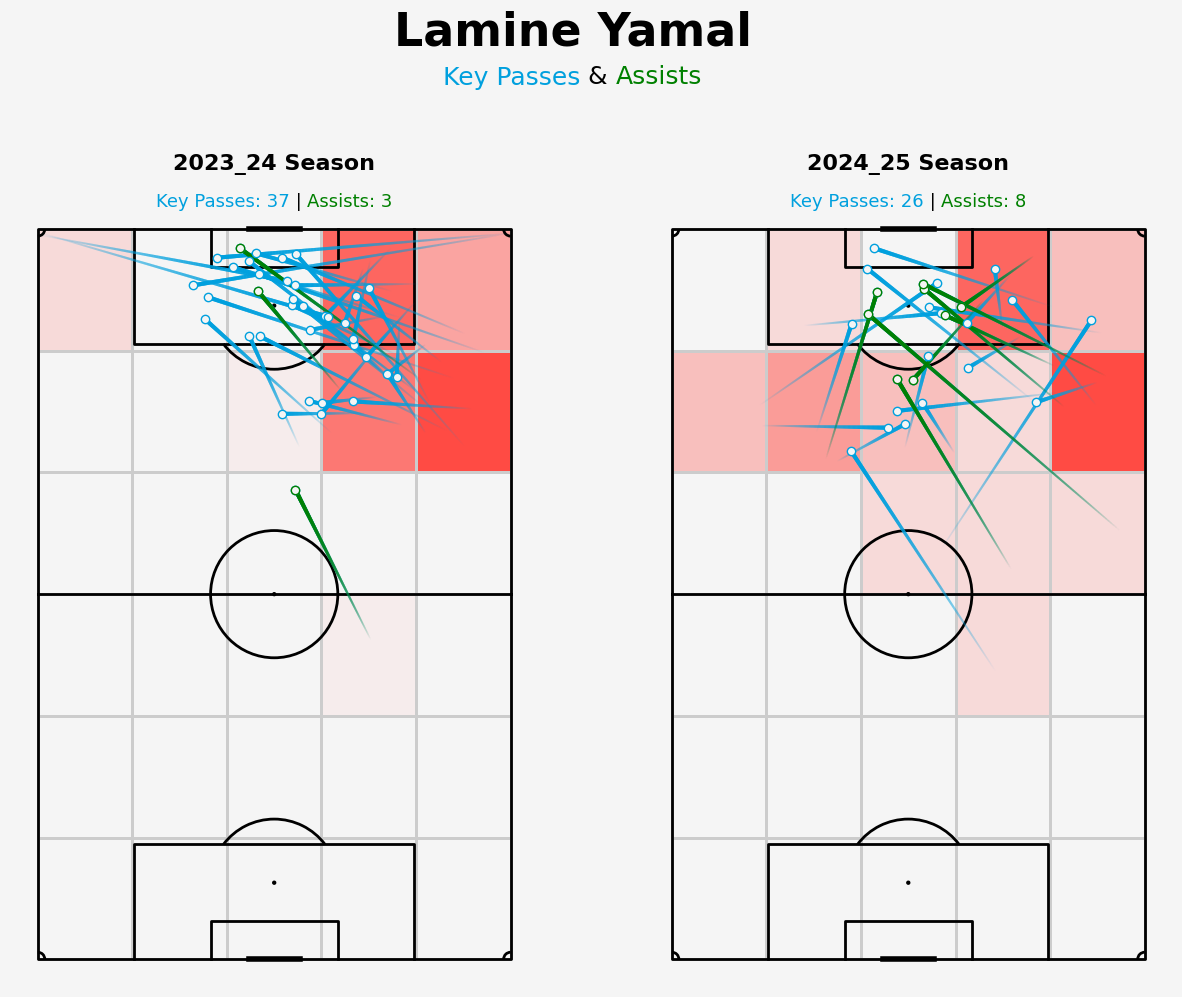

In [99]:
def shotassist(ax, dfu, ssn, pname):
    dfp = dfu[dfu['name']==pname]
    kp = dfp[(dfp['type']=='Pass') & (dfp['qualifiers'].str.contains('KeyPass'))].reset_index(drop=True)
    ass = dfp[(dfp['type']=='Pass') & (dfp['qualifiers'].str.contains('GoalAssist'))].reset_index(drop=True)

    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color, linewidth=2, corner_arcs=True, line_zorder=2)
    pitch.draw(ax=ax)

    pitch.lines(kp.x, kp.y, kp.endX, kp.endY, color=col2, comet=True, transparent=True, lw=3, ax=ax, zorder=3)
    pitch.scatter(kp.endX, kp.endY, color=bg_color, ec=col2, ax=ax, zorder=5)
    pitch.lines(ass.x, ass.y, ass.endX, ass.endY, color='green', comet=True, transparent=True, lw=3, ax=ax, zorder=4)
    pitch.scatter(ass.endX, ass.endY, color=bg_color, ec='green', ax=ax, zorder=6)

    pc_map = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [bg_color, col1], N=20)
    bin_statistic = pitch.bin_statistic(kp.x, kp.y, bins=(6,5), statistic='count', normalize=True)
    pitch.heatmap(bin_statistic, ax=ax, cmap=pc_map, edgecolors='#cccccc', linestyle='dotted')
    

    ax_text(34, 109, f'<Key Passes: {len(kp)}> | <Assists: {len(ass)}>', fontsize=13, highlight_textprops=[{'color':col2}, {'color': 'green'}],
            ha='center', va='center', ax=ax)

    if ssn == '23-24':
        ax.set_title('2023_24 Season', fontsize=16, fontweight='bold', y=1.03)
    if ssn == '24-25':
        ax.set_title('2024_25 Season', fontsize=16, fontweight='bold', y=1.03)

    return

fig,axs = plt.subplots(1,2, figsize=(15,15), facecolor=bg_color)
shotassist(axs[0], fcb23_24, '23-24', 'Lamine Yamal')
shotassist(axs[1], fcb24_25, '24-25', 'Lamine Yamal')

fig.text(0.5, 0.87, 'Lamine Yamal', fontsize=33, fontweight='bold', ha='center', va='center')
fig_text(0.5, 0.84, '<Key Passes> & <Assists>', fontsize=18, ha='center', va='center', ax=fig,
         highlight_textprops=[{'color':col2}, {'color': 'green'}])

# fig.adjust(wspace=0.01)

C:\Users\h\AppData\Local\Temp\ipykernel_18512\224499708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pro_car['len'] = np.sqrt(
C:\Users\h\AppData\Local\Temp\ipykernel_18512\224499708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pro_car['len'] = np.sqrt(


Text(0.5, 0.84, 'Progressive Caries')

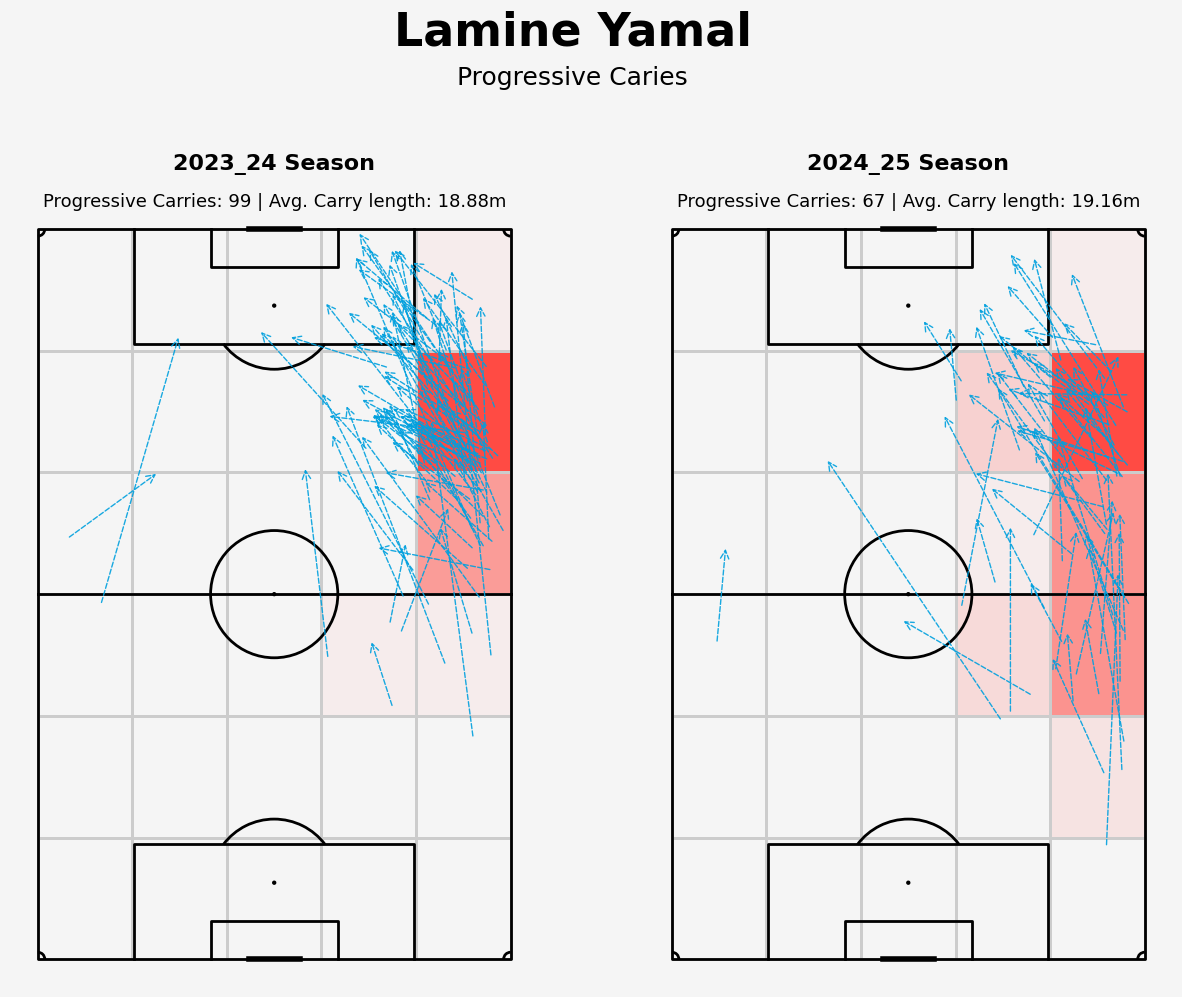

In [107]:
def pro_carries(ax, dfu, ssn, pname):
    dfp = dfu[dfu['name']==pname]
    pro_car = dfp[(dfp['type']=='Carry') & (dfp['prog_carry']>=10)]
    pro_car['len'] = np.sqrt(
        (pro_car['x'] - pro_car['endX'])**2 + (pro_car['y'] - pro_car['endY'])**2
    )
    avg_len = round(pro_car['len'].mean(), 2)

    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color, linewidth=2, corner_arcs=True, line_zorder=2)
    pitch.draw(ax=ax)

    for index, row in pro_car.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->', color=col2, zorder=4, mutation_scale=15, 
                                        alpha=0.9, linewidth=1, linestyle='--')
        ax.add_patch(arrow)

    pc_map = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [bg_color, col1], N=20)
    bin_statistic = pitch.bin_statistic(pro_car.x, pro_car.y, bins=(6,5), statistic='count', normalize=True)
    pitch.heatmap(bin_statistic, ax=ax, cmap=pc_map, edgecolors='#cccccc', linestyle='dotted')
    

    ax.text(34, 109, f'Progressive Carries: {len(pro_car)} | Avg. Carry length: {avg_len}m', fontsize=13, ha='center', va='center')

    if ssn == '23-24':
        ax.set_title('2023_24 Season', fontsize=16, fontweight='bold', y=1.03)
    if ssn == '24-25':
        ax.set_title('2024_25 Season', fontsize=16, fontweight='bold', y=1.03)

    return

fig,axs = plt.subplots(1,2, figsize=(15,15), facecolor=bg_color)
pro_carries(axs[0], fcb23_24, '23-24', 'Lamine Yamal')
pro_carries(axs[1], fcb24_25, '24-25', 'Lamine Yamal')

fig.text(0.5, 0.87, 'Lamine Yamal', fontsize=33, fontweight='bold', ha='center', va='center')
fig.text(0.5, 0.84, 'Progressive Caries', fontsize=18, ha='center', va='center')